In [89]:
from typing import Callable, List
from functools import partial, reduce

import numpy as np
import matplotlib.pyplot as plt
from numpy import ndarray

plt.rcParams["figure.figsize"] = (20,10)

In [90]:
"""
Finds gradient of function fun in point x with precision h.
"""
def grad(fun:Callable[[ndarray], float], x:ndarray, h:float=1e-5) -> ndarray:
    dim = len(x)
    g = np.zeros(dim)
    step = np.zeros(dim)
    for i in range(dim):
        step[i] = h
        g[i] = (fun(x + step) - fun(x - step)) / (2 * h)
        step[i] = 0
    return g

"""
Finds "partial" gradient of function represented in the form of sum.
Calculates sum of derivatives of some terms of function fun in a row.

@param fun: list of terms of the function to find partial gradient for
@param x: point in which derivatives are calculated
@param r: list of 2 elements. 1 element shows the first term in list fun for which gradiant will be found. 2 element shows for how many terms after first term gradient will be found
@param h: precision of calculated gradients

@returns r[1] dimensional list containing sum of calculated gradients
"""
def grad_appr(fun:List[Callable[[ndarray], float]], x:ndarray, r:List=(0, 1), h:float=1e-5) -> ndarray:
    sum = np.zeros(len(x))
    begin = r[0]
    n = r[1]
    for i in range(n):
        sum += grad(fun[(begin + i) % len(fun)], x, h)
    return sum

"""
Generates data set for multiple linear regression.
Guaranteed that expected value of noise equals to 0. Every regressor is len(b) - 1 dimensional vector.
Both regressors and dependent variables lists has size equals to size.


Для облегчения понимания можно считать, что функция генерирует точки, смещённые относительно некоторой гиперплоскости вверх или вниз.

p[1:] в некотором роде задаёт нормаль к этой гиперплоскости. p[0] - смещение гиперплоскости вверх или вниз относительно начала координат, length - её длина. k или шум характеризует то, насколько сгенерированные точки будут отклоняться от гиперплоскости, которую мы приближаем. size - количество точек на гиперплоскости.

В итоге получается два массива: точки на гиперплоскости и высоты этих точек.


@param b: list characterising linear relationship between regressors (independent variables) and dependent variable. b[0] is dependent variable offset
@param k: noise (error term) max absolute value
@param size: number of points (data instances) in data set
@param r: tuple describing range in which regressors (feature) will be generated

@return list of two elements: list of regressors and list of dependent values
"""
def generate_dataset(b:List[float], k:int, size:int=50, r:tuple = (0, 10)) -> List[List[float]]:
    # t += (np.random.rand(len(t)) - 0.5) * 2 * k
    h, b = b[0], b[1:]
    dim = len(b)
    # *[t]*dim is equals to *np.tile(t, dim).reshape((dim, -1))
    regressors = np.random.rand(size, dim) * (r[1] - r[0]) + r[0]
    # Noise
    e = (np.random.rand(len(regressors)) - 0.5) * 2 * k
    dependent_var = np.sum(b * regressors, axis=1) + h + e
    return [regressors, dependent_var]

"""
Generates function which minimum point is the solution for linear regression problem for dataset [t, ft].
It is pretty slow.

@param t: list of regressors
@param ft: list of dependent values

@return list of terms of generated function (every term represents distance from minimized function to one point from dataset)
"""
def generate_minimized_fun(t:List[List[float]], ft:List[float]) -> List[Callable[[List[float]], float]]:
    sum_fun = np.empty(len(t), dtype=partial)
    for i in range(len(t)):
        # Captures t[i], ft[i] and len(t) from current context
        sum_fun[i] = partial(lambda t, ft, l, a: 1 / (2 * l) * np.square(a[0] + np.sum(a[1:] * t) - ft), t[i], ft[i], len(t))
        # or
        # sum_fun[i] = partial(lambda t, ft, l, a: 1 / (2 * l) * np.square(np.sum(a * np.concatenate(([1], t))) - ft), t[i], ft[i], len(t))
    np.random.shuffle(sum_fun)
    return sum_fun

"""
Generates function which minimum point is the solution for linear regression problem for dataset [t, ft].
Similar to generate_minimized_fun but every regressor is 1 dimensional vector (i.e. minimized function has two arguments). You should use this function only when it's necessary to plot minimized function. Function generated by generate_minimized_two_variable_fun works fine when arguments are arrays unlike generate_minimized_fun.

@param t: list of regressors
@param ft: list of dependent values

@return list of terms of generated function (every term represents distance from generated function to one point from dataset)
"""
def generate_minimized_two_variable_fun(t:List[List[float]], ft:List[float]) -> List[Callable[[List[float]], float]]:
    sum_fun = np.empty(len(t), dtype=partial)
    for i in range(len(t)):
        # Captures t[i], ft[i] and len(t) from current context
        sum_fun[i] = partial(lambda t, ft, l, a: 1 / (2 * l) * np.square(a[0] + a[1] * t - ft), t[i], ft[i], len(t))
    np.random.shuffle(sum_fun)
    return sum_fun

"""
Generates function from terms. Every term is function. Every function from terms should accept equal amount of parameters.

@return function representing sum of functions from terms
"""
def fun_from_terms(terms:List[Callable[[List[float]], float]]) -> Callable[[List[float]], float]:
    return reduce(lambda f1, f2: lambda x: f1(x) + f2(x), terms)

class StandartScaler:
    """
    Offers functionality to perform standart scaling.

    Works perfect when data generated by generate_dataset function.

    @param t: list of data instances to calculate mean and deviation for
    """
    def __init__(self, t:ndarray):
        self.mean = np.mean(t, axis=0)
        self.deviation = np.std(t, axis=0)

    """
    Scales features (regressors) in data instances. Mean and standard deviation after scaling equals to 0 and 1 respectively.

    @param t: list of data instances

    @return list of data instances with scaled features
    """
    def scale(self, t:ndarray) -> ndarray:
        return (t - self.mean) / self.deviation

    """
    Do reverse scaling.

    @param t: list of scaled data instances

    @return list of data instances before scale
    """
    def scale_reverse(self, t:ndarray) -> ndarray:
        return t * self.deviation + self.mean

    """
    Calculates min point of function with unscaled data instances using min point of function with scaled data instances

    @param min_point: scaled min point

    @return initial min point
    """
    def reverse_min_point(self, min_point:ndarray) -> ndarray:
        return np.concatenate([min_point[0] - min_point[1:] * self.mean / self.deviation, min_point[1:] / self.deviation])

"""
! Deprecated
Scales features (regressors) in data instances. Every feature value is in range [r[0], r[1]] after scaling.

As data set returned from generate_dataset distributed normally within each feature, it is better to do NOT use this scale if data set generated with generate_dataset.

@param t: list of data instances

@return list of data instances with scaled features
"""
def min_max_scale(t, r=(0, 1)):
    return (t - np.min(t, axis=0)) / (np.max(t, axis=0) - np.min(t, axis=0)) * (r[1] - r[0]) + r[0]

"""
Plots level lines of two variable function represented by terms.

@param terms: list of terms of plotted function (should be result of generate_minimized_two_variable_fun)
@param points: list of points at which plot level lines
@param offset: characterizes scale of the plot
"""
def plot_path_contours(terms:List[Callable[[List[float]], float]], points:List[List[float]], offset:float=None) -> None:
    min_point = points[-1]
    ax = plt.figure(figsize=(20, 20)).add_subplot()
    ax.plot(points[:, 0], points[:, 1], 'o-')
    fun = fun_from_terms(terms)
    if offset is None:
        offset = np.max(min_point) * 1.2
    ttX = np.linspace(min_point[0] - offset, min_point[0] + offset, 200)
    ttY = np.linspace(min_point[1] - offset, min_point[1] + offset, 200)
    X, Y = np.meshgrid(ttX, ttY)
    plt.title('SGM path and level curves', fontsize=22)
    ax.contour(X, Y, fun([X, Y]), levels=np.sort(np.unique([fun(point) for point in points])))

"""
Plots 2d plot of two variable linear function represented by fun_coeffs. fun_coeffs[0] represents height offset.
"""
def plot_dataset_and_function(t:List[List[float]], ft:List[float], fun_coeffs:List[float]) -> None:
    ax = plt.figure().add_subplot()
    ax.plot(t, ft, 'o', markersize=1)
    tt = np.linspace(np.min(t), np.max(t), 1000)
    plt.title('Data set and evaluated function', fontsize=22)
    ax.plot(tt, fun_coeffs[1] * tt + fun_coeffs[0])

"""
Plots how SGD approach to minimum point along each coordinate.
"""
def plot_convergence(points:ndarray) -> None:
    ax = plt.figure().add_subplot()
    plt.title('Convergence plot', fontsize=22)
    ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
    ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

"""
Prints data describing effectiveness of SGD.

@param actual_min: real minimum point of evaluated function
@param point: path of SGD
"""
def print_result(actual_min:ndarray, points:ndarray, min_point:float=None) -> None:
    if min_point is None:
        min_point = points[-1]
    print(f'Precision: {actual_min - min_point}')
    print(f'Min point: {min_point}')
    print(f'Iterations: {len(points)}')
    print(f'Path: {points}')

"""
Finds minimum of the function sum_fun using stochastic gradient descent (sgd).

@param sum_fun: function in form of list of terms to find minimum for
@param x: point to begin finding minimum in
@param max_epoch: upper bound for the number of iterations (if param stop_criteria is default number of iterations equals to max_epoch)
@param batch_size: number of terms of sum_fun to find gradient for on each iteration
@param lr: initial value of learning rate (shows how big will be steps on each iteration)
@param scheduler: how learning rate will be changing during iterations (when default learning rate is constant)
@param stop_criteria: alternative to max_epoch stopping criterion (when default never fulfill)

@return list of points representing path of sgd. The last point of the list is found minimum point. Number of points represents number of epoch until stopping criteria is true or max_epoch reached
"""
def sgd(sum_fun:List[Callable[[ndarray], float]], x:ndarray, max_epoch:int, batch_size:int, lr:List[float], scheduler:Callable[[List[float]], float]=lambda lr: lr, stop_criteria:Callable[[List[float]], bool]=lambda x: False) -> ndarray:
    lr = np.array(lr)
    points = [x]
    for i in range(1, max_epoch):
        if stop_criteria(x): break
        x = x - 1 / batch_size * scheduler(lr) * np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        points.append(x)
    return np.array(points)

## Решение задачи простой линейной регрессии (одномерное пространство регрессоров)
Приближает прямую в двумерном пространстве

Precision: [-0.02645008 -0.01644945]
Min point: [10.02645008 -3.98355055]
Iterations: 42
Path: [[ 0.          0.        ]
 [ 1.61162289 -0.89087877]
 [ 3.77432806 -2.02414618]
 [ 4.50817798 -2.36198546]
 [ 5.2348962  -2.66699182]
 [ 6.19539135 -2.95799423]
 [ 6.58076791 -3.24881605]
 [ 7.06387485 -3.40238652]
 [ 7.33311411 -3.40240099]
 [ 7.36078006 -3.59877442]
 [ 7.73122961 -3.67647729]
 [ 8.03947515 -3.68328614]
 [ 8.58676495 -3.80810539]
 [ 8.81641439 -3.92139572]
 [ 8.97801088 -4.00341183]
 [ 8.9986413  -4.0258705 ]
 [ 9.32402706 -4.05023377]
 [ 9.25453385 -4.0162761 ]
 [ 9.13701358 -4.05634242]
 [ 9.47578145 -3.99533513]
 [ 9.38402443 -4.00994198]
 [ 9.41904691 -3.97201403]
 [ 9.54076081 -4.01191659]
 [ 9.46321467 -4.02213715]
 [ 9.37247062 -4.09234658]
 [ 9.26829733 -4.0837996 ]
 [ 9.20203367 -4.08314979]
 [ 9.07043744 -4.15393728]
 [ 8.80964486 -4.04601575]
 [ 8.99094344 -4.01024811]
 [ 9.42459945 -3.89693101]
 [ 9.69772677 -3.91489312]
 [ 9.30704338 -3.88867011]
 [ 9.519223   

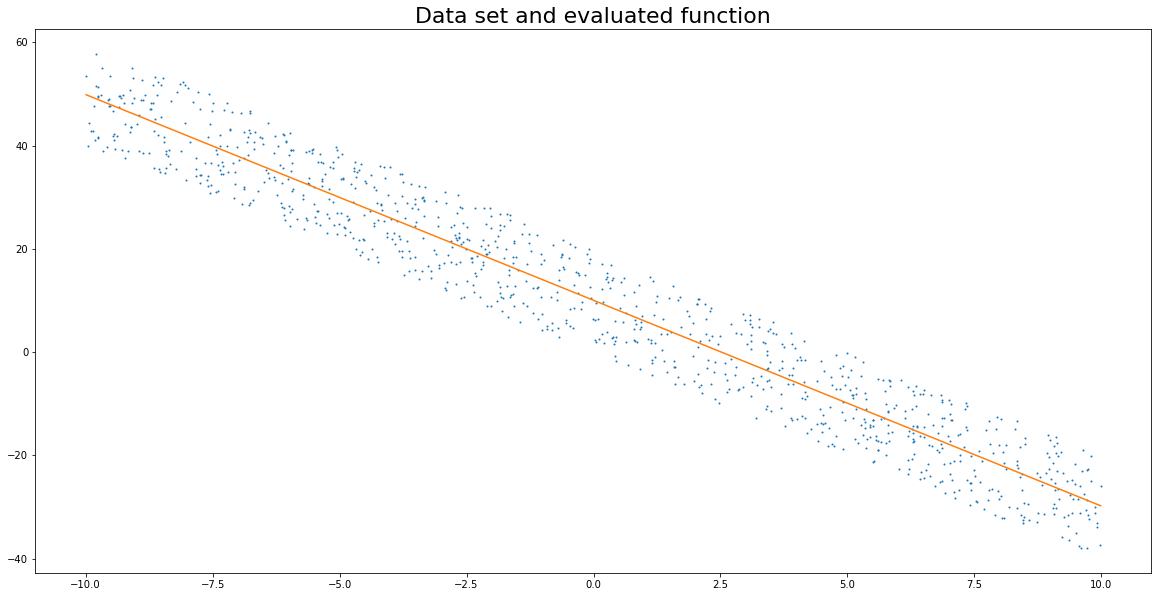

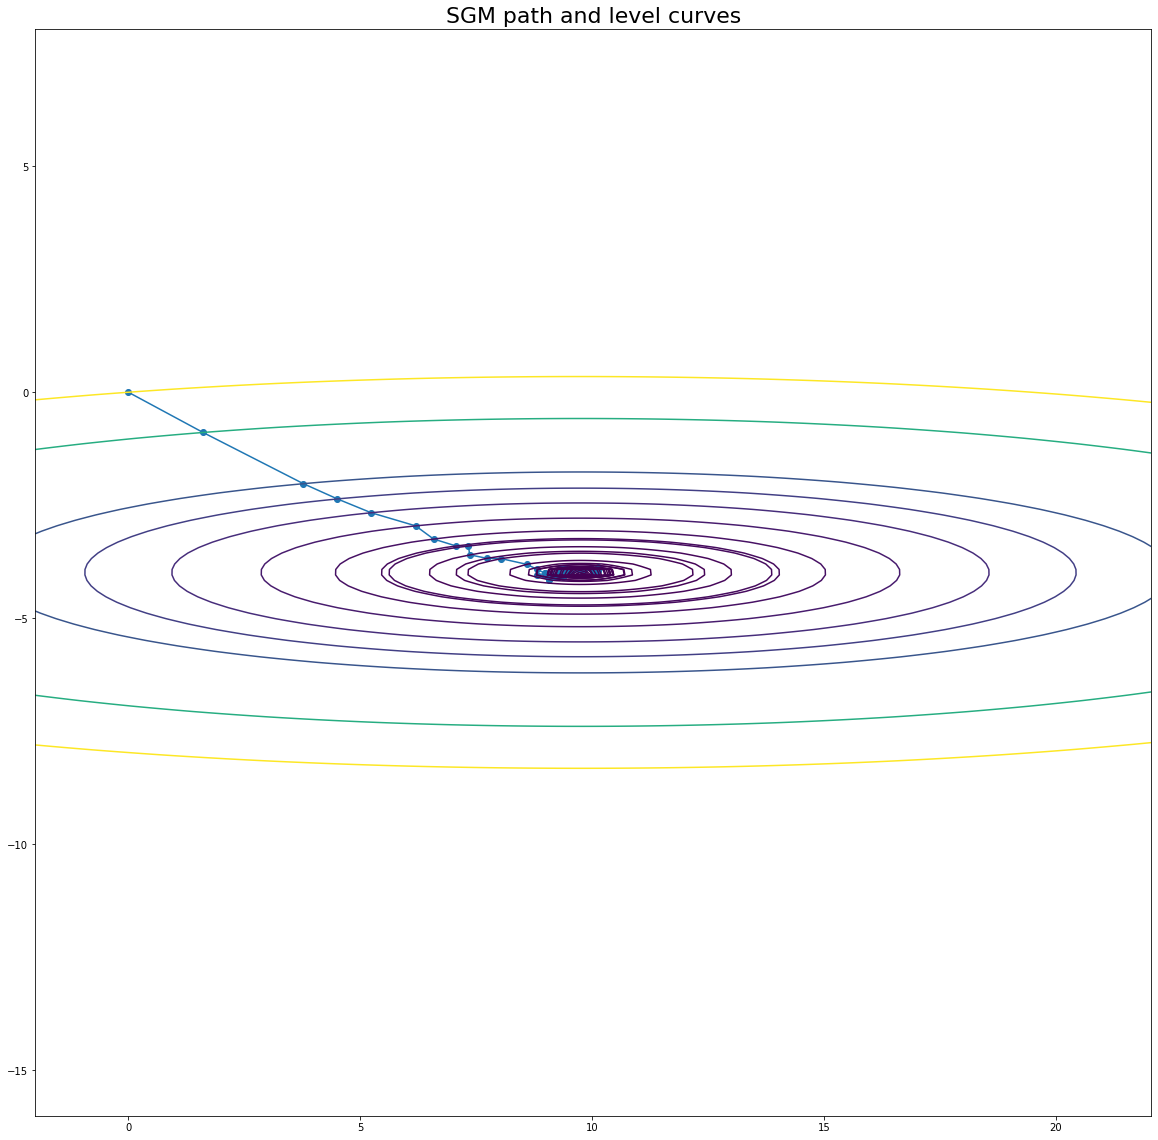

In [91]:
a = [10, -4]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 50
batch_size = 20
lr = [150, 8]

points = sgd(sum_fun, x, epoch, batch_size, lr, stop_criteria=lambda x: (np.abs(x - a) < 0.05).all())

print_result(a, points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## Решение задачи линейной регрессии (для двумерного пространства регрессоров)
Приближает плоскость в трёхмерном пространстве

Precision: [ 0.18877052  0.02549046 -0.09652891]
Min point: [9.81122948 1.97450954 4.09652891]
Iterations: 50
Path: [[ 0.          0.          0.        ]
 [ 1.07825849  0.21875797  0.79095387]
 [ 2.1405523   0.38322075  1.48031955]
 [ 2.48897114  0.58430177  1.87332181]
 [ 4.4087218   0.90768494  2.57515353]
 [ 5.40123772  0.99492181  2.8270541 ]
 [ 6.50454051  1.10789533  3.32524075]
 [ 7.06210507  1.16244276  3.48954578]
 [ 7.38782433  1.24296706  3.71791193]
 [ 8.41124155  1.35454135  3.98164963]
 [ 8.52017655  1.47024449  3.97866294]
 [ 8.78328819  1.52110268  3.98521709]
 [ 9.08999322  1.60742719  4.00314223]
 [ 9.08600042  1.67307056  3.95081604]
 [ 9.30394831  1.70194132  3.96899789]
 [ 9.23599493  1.78960885  3.95979343]
 [ 9.21070762  1.89133612  4.00269023]
 [ 9.22153657  1.9204049   3.99156018]
 [ 8.79943982  1.89765363  4.03686634]
 [ 9.27344483  1.94635665  3.95706243]
 [ 9.13413471  1.97334078  4.0252201 ]
 [ 9.41191971  1.92030728  4.11482221]
 [ 9.55608289  1.90012944 

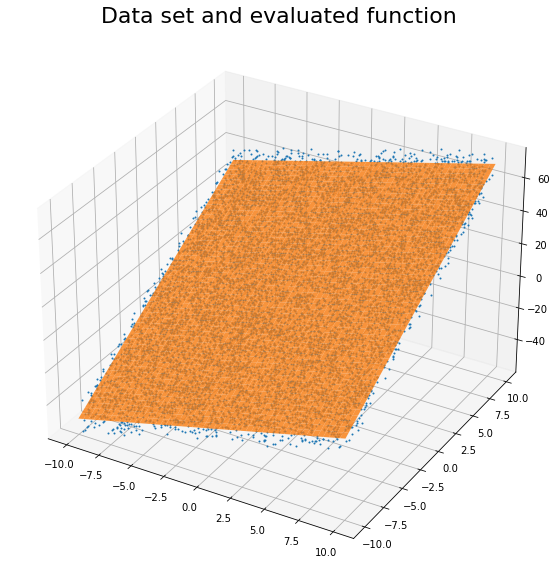

In [92]:
a = [10, 2, 4]
t, ft = generate_dataset(a, 10, 10000, (-10, 10))
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(3)
epoch = 50
batch_size = 20
lr = [1500, 40, 80]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print_result(a, points)
ax = plt.figure().add_subplot(projection='3d')
# Plots dataset
plt.title('Data set and evaluated function', fontsize=22)
ax.plot(t[:, 0], t[:, 1], ft, 'o', markersize=1)
# Plots approximated function
tt = np.linspace(-10, 10, 1000)
X, Y = np.meshgrid(tt, tt)
ax.plot_surface(X, Y, min_point[0] + min_point[1] * X + min_point[2] * Y, alpha=0.8)

## 4-мерное пространство регрессоров

In [93]:
a = [10, 2, 4, 5, -3]
t, ft = generate_dataset(a, 10, 100000, (-10, 10))
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(5)
epoch = 50
batch_size = 3
lr = [7500, 120, 160, 200, 120]

points = sgd(sum_fun, x, epoch, batch_size, lr)

print_result(a, points)

Precision: [ 2.34092755  0.20238299  0.20112297  0.23142423 -0.66723163]
Min point: [ 7.65907245  1.79761701  3.79887703  4.76857577 -2.33276837]
Iterations: 50
Path: [[ 0.          0.          0.          0.          0.        ]
 [-2.30505971  0.17368911  0.13459485  0.35516823 -0.05477833]
 [-0.77644346  0.33223563 -0.06838976  0.65844456 -0.3161382 ]
 [ 3.02589219  0.50908009  0.50723748  1.55965079 -0.46650103]
 [ 3.54351674  0.78387578  0.89014697  1.8796984  -0.8392969 ]
 [ 3.20892745  0.88525247  0.81590619  2.04767789 -0.86604494]
 [ 1.24449589  0.86447933  1.00961481  2.38913604 -0.85089749]
 [ 2.59760836  1.05628541  1.05923939  2.69629091 -0.82769703]
 [ 2.62738586  1.00794289  1.04976163  2.75162461 -0.96859991]
 [ 2.56328543  1.00116827  1.02026256  2.789143   -1.01323103]
 [ 4.79416937  1.05240225  1.3391476   2.95362774 -1.15166723]
 [ 5.08408254  1.14176489  1.30642535  3.10804361 -1.32366039]
 [ 4.75488102  1.17643159  1.3788781   3.31712959 -1.3118516 ]
 [ 4.77118902 

## 100-мерное пространство регрессоров

In [94]:
n = 101
a = np.random.randint(-10, 10, n)
t, ft = generate_dataset(a, 10, 1000000, (-10, 10))
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(n)
epoch = 50
batch_size = 20
lr = 120

points = sgd(sum_fun, x, epoch, batch_size, lr)

print_result(a, points)

Precision: [-8.97544791 -2.41521611 -0.44944098 -5.52496486 -3.13787027  1.92865659
  3.52445537  2.8219719   6.85669883  5.29016178  0.52799747  2.84160765
 -4.62047859 -7.16760418 -6.5335822  -5.82396179  0.19245172 -7.24125984
  1.36690864 -3.77836632 -1.19750078 -0.41704802  6.19055329 -7.08915105
 -7.81432257  0.77094442 -1.31801884  1.15937116  2.61695657 -1.57657775
 -0.48606544 -0.23223195  5.36107461  5.50725611  3.70476868  2.79869419
 -2.77491558 -6.67000092  6.26715825 -1.19292066 -7.63893743 -6.62720533
 -2.38246424 -5.67329987  2.20622899  3.36394842  6.22377149 -6.52249663
  5.00205948 -8.27457369  6.77061424 -2.98066984  7.64193958 -6.65847198
  5.89963063 -0.21208743 -4.16513857 -3.37307486 -2.94933533  5.00921685
 -4.45515385  6.64484595  6.26712142  5.12159324  7.1671654  -7.36511114
 -7.99233926 -4.30184567 -1.27666484 -5.94866372 -6.32832514  5.12283475
  0.49066972 -7.79775477 -8.27281462 -0.41356785 -7.18363129  3.0927607
  5.93780492  0.09851646  7.18311429  1.6

## Сходимость в зависимости от размера batch
Двумерное пространство регрессоров. Можно заметить, что с повышением размера batch графики отклонений становятся всё плавнее, стремясь к некоторой точке, близкой к нулю.

[[ 2.02207301e-01 -4.99150795e-01  5.54300679e-01]
 [ 1.87883909e-01 -5.67742484e-02  2.05096158e-01]
 [ 7.59736670e-01  1.31129003e-02  2.06647816e-01]
 [ 4.79960532e-01 -1.08820787e-01  1.44549038e-01]
 [ 9.28884857e-01  6.62303386e-02 -1.50692513e-01]
 [ 5.79757481e-01 -1.45382052e-01 -5.07529495e-02]
 [ 9.58280476e-01  7.04965682e-02 -1.36794178e-01]
 [ 7.10993773e-01 -1.02310620e-01 -5.43900173e-02]
 [ 9.93076208e-01  6.00741083e-02 -2.20676547e-01]
 [ 6.98623380e-01 -1.13128244e-01 -8.70313525e-02]
 [ 9.81046629e-01  3.67346743e-02 -1.57288631e-01]
 [ 7.53634233e-01 -1.08351249e-01 -3.39501553e-02]
 [ 1.09200701e+00 -2.45894762e-02 -1.31504132e-01]
 [ 7.39530394e-01 -1.05944263e-01 -2.21817590e-02]
 [ 1.04606036e+00 -3.19973700e-02 -6.36433866e-02]
 [ 8.11219282e-01 -9.07320714e-02 -1.12640877e-02]
 [ 1.01366781e+00 -3.31208416e-02 -6.07586134e-02]
 [ 7.84078490e-01 -8.66569800e-02 -2.04496078e-02]
 [ 1.03500666e+00 -5.42710037e-02 -1.25453201e-01]
 [ 8.33503462e-01 -8.71914149e-

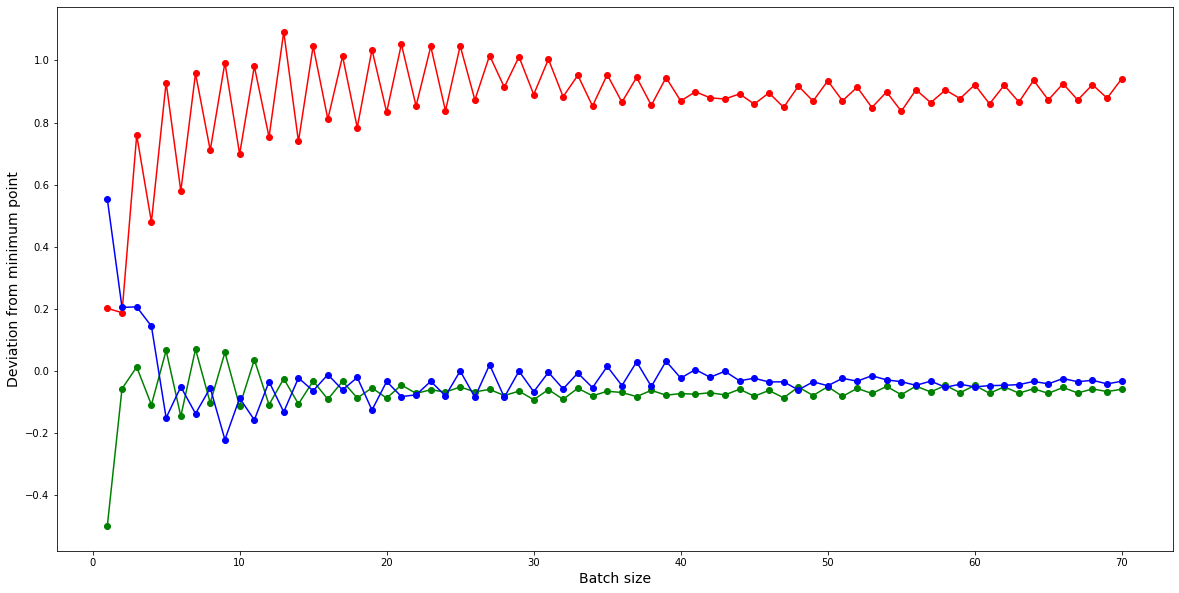

In [95]:
a = [25, 2, 15]
t, ft = generate_dataset(a, 10, 100, (-10, 10))
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(3)
epoch = 50
lr = [9, 0.5, 1]
scheduler = lambda lr: np.array(lr) * np.exp(-0.01)

n = 70
min_points = []
for batch_size in range(1, n + 1):
    min_points.append(sgd(sum_fun, x, epoch, batch_size, lr)[-1])

min_points = np.array(min_points)
deviation = a - min_points
print(deviation)
print(min_points)

tt = np.linspace(1, n, n)
plt.gca().set_xlabel('Batch size', fontsize=14)
plt.gca().set_ylabel('Deviation from minimum point', fontsize=14)
plt.plot(tt, deviation[:, 0], '-o', color='red')
plt.plot(tt, deviation[:, 1], '-o', color='green')
plt.plot(tt, deviation[:, 2], '-o', color='blue')

## Решение задачи простой линейной регрессии с использованием standart scaler
Видно, что после scaling функция изменяется более одинаково по всем измерениям. Значительное улучшение сходимости. Отсутствие необходимости подбирать lr по каждой переменной.

Precision: [0.84562869 0.28942122]
Min point: [9.15437131 4.71057878]
Iterations: 20
Path: [[ 0.          0.        ]
 [ 1.32589475  3.75296472]
 [ 2.98102825  6.58457867]
 [ 3.84240794  9.1452413 ]
 [ 3.64516343 11.53270362]
 [ 4.92611675 14.50306272]
 [ 5.42876784 16.34850582]
 [ 5.81756138 17.63963621]
 [ 6.24849061 18.7710139 ]
 [ 6.99538605 21.03181588]
 [ 7.1416204  21.64217051]
 [ 7.55235274 22.54671391]
 [ 8.21574905 23.68730383]
 [ 8.43796844 24.39786654]
 [ 8.86229397 25.03012188]
 [ 8.94873274 25.41957826]
 [ 9.2803172  25.91124218]
 [ 9.47157037 26.44452878]
 [ 9.26459059 26.84652464]
 [ 9.67234824 27.55890112]]


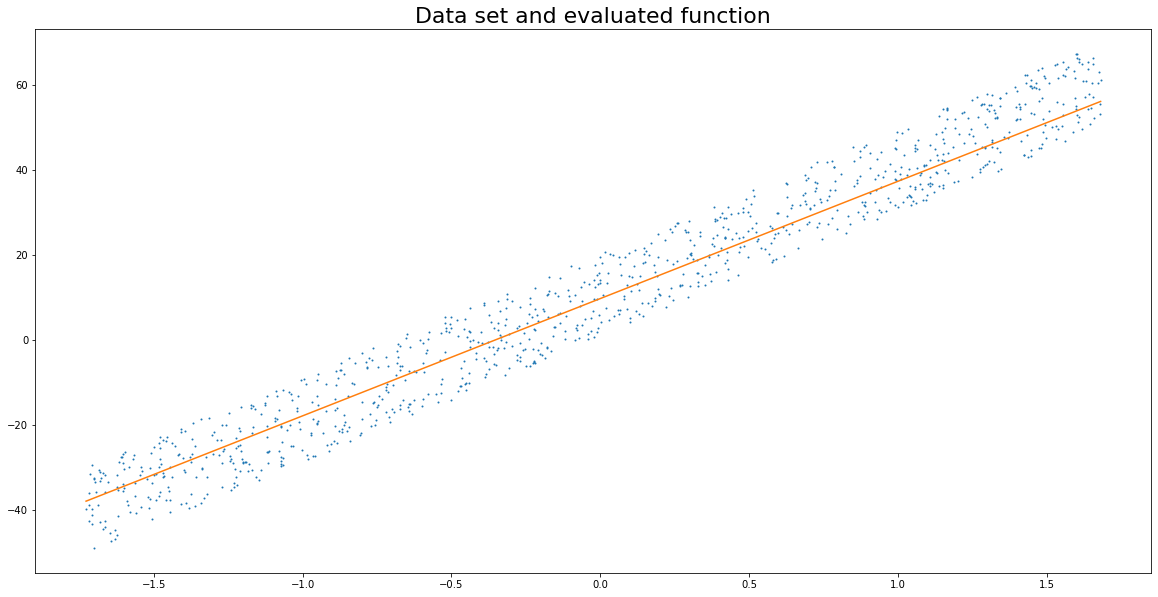

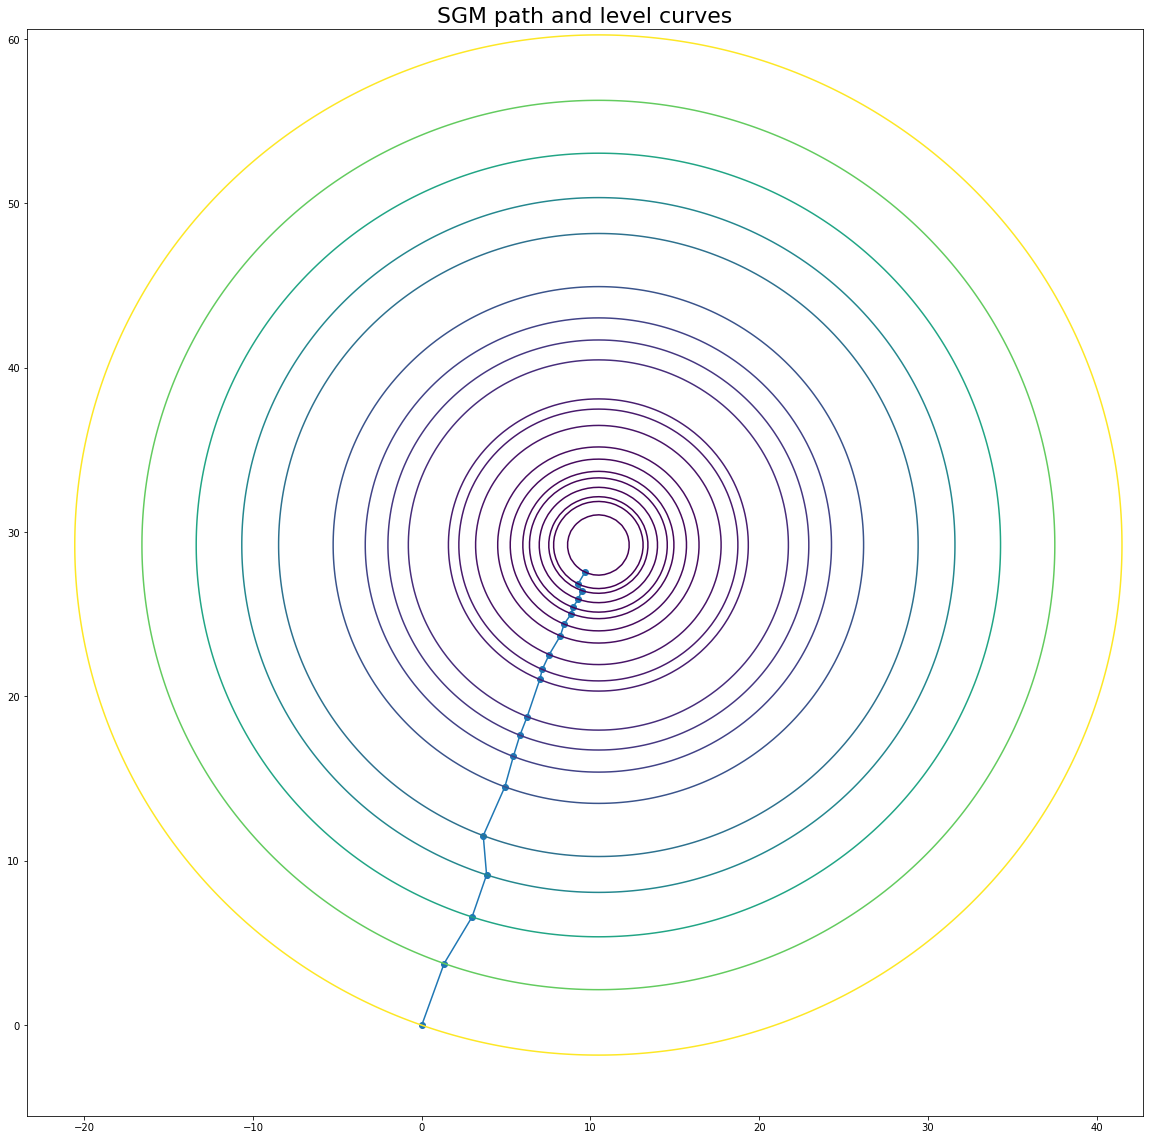

In [96]:
a = [10, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
scaler = StandartScaler(t)
t = scaler.scale(t)
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = 120

points = sgd(sum_fun, x, epoch, batch_size, lr)

print_result(a, points, scaler.reverse_min_point(points[-1]))
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## Сравнение до и после standart scaling

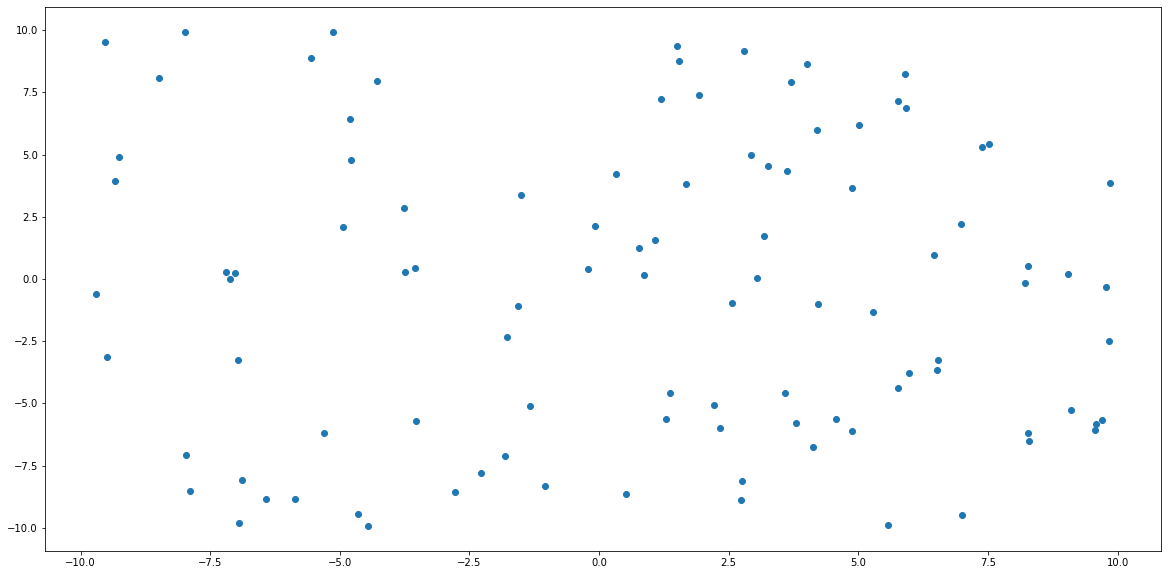

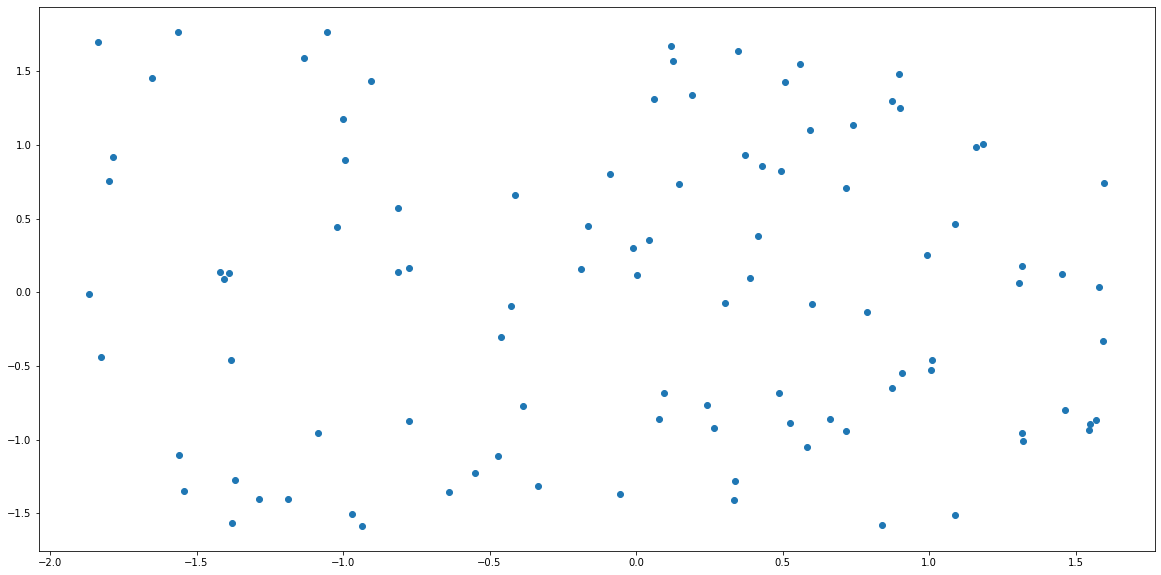

In [97]:
a = [10, -3, 5]
t = generate_dataset(a, 3, 100, (-10, 10))[0]

ax = plt.figure().add_subplot()
ax.plot(t[:, 0], t[:, 1], 'o')

scaler = StandartScaler(t)
t = scaler.scale(t)

ax = plt.figure().add_subplot()
ax.plot(t[:, 0], t[:, 1], 'o')

## SGM with momentum

Precision: [0.75863164 0.02879489]
Min point: [9.24136836 4.97120511]
Iterations: 20
Path: [[ 0.          0.        ]
 [-0.242763    0.57584857]
 [ 0.5253549   1.64693535]
 [ 1.44607158  2.77698482]
 [ 2.26181472  3.73947606]
 [ 3.14549423  4.3509111 ]
 [ 3.99971131  4.71827512]
 [ 4.74756679  4.97752274]
 [ 5.48779963  5.18032312]
 [ 6.12829217  5.24868237]
 [ 6.62171095  5.27929736]
 [ 7.02476969  5.2189429 ]
 [ 7.49599191  5.12903216]
 [ 7.96766603  5.0260579 ]
 [ 8.32283541  4.98996738]
 [ 8.56502832  4.97241778]
 [ 8.82030155  4.9192642 ]
 [ 9.08869708  4.90844222]
 [ 9.23642077  4.92690071]
 [ 9.24136836  4.97120511]]


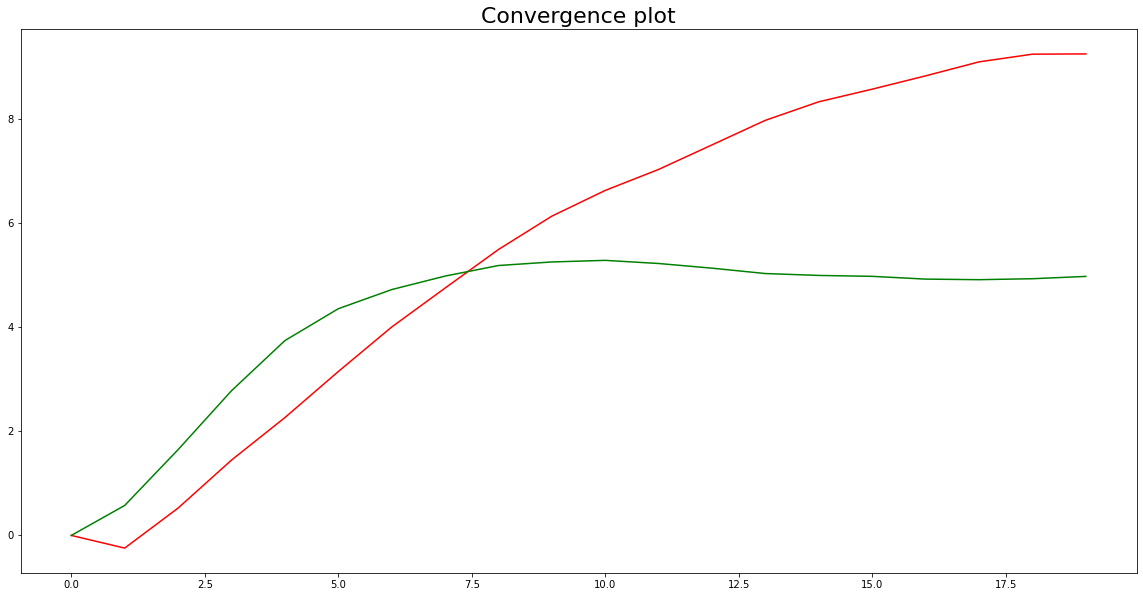

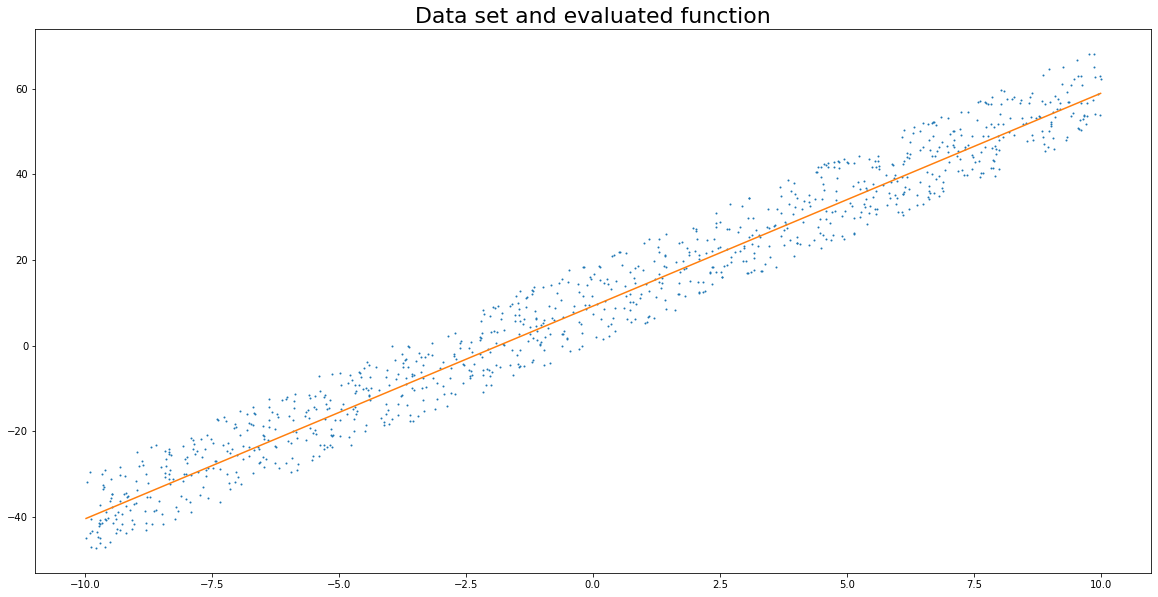

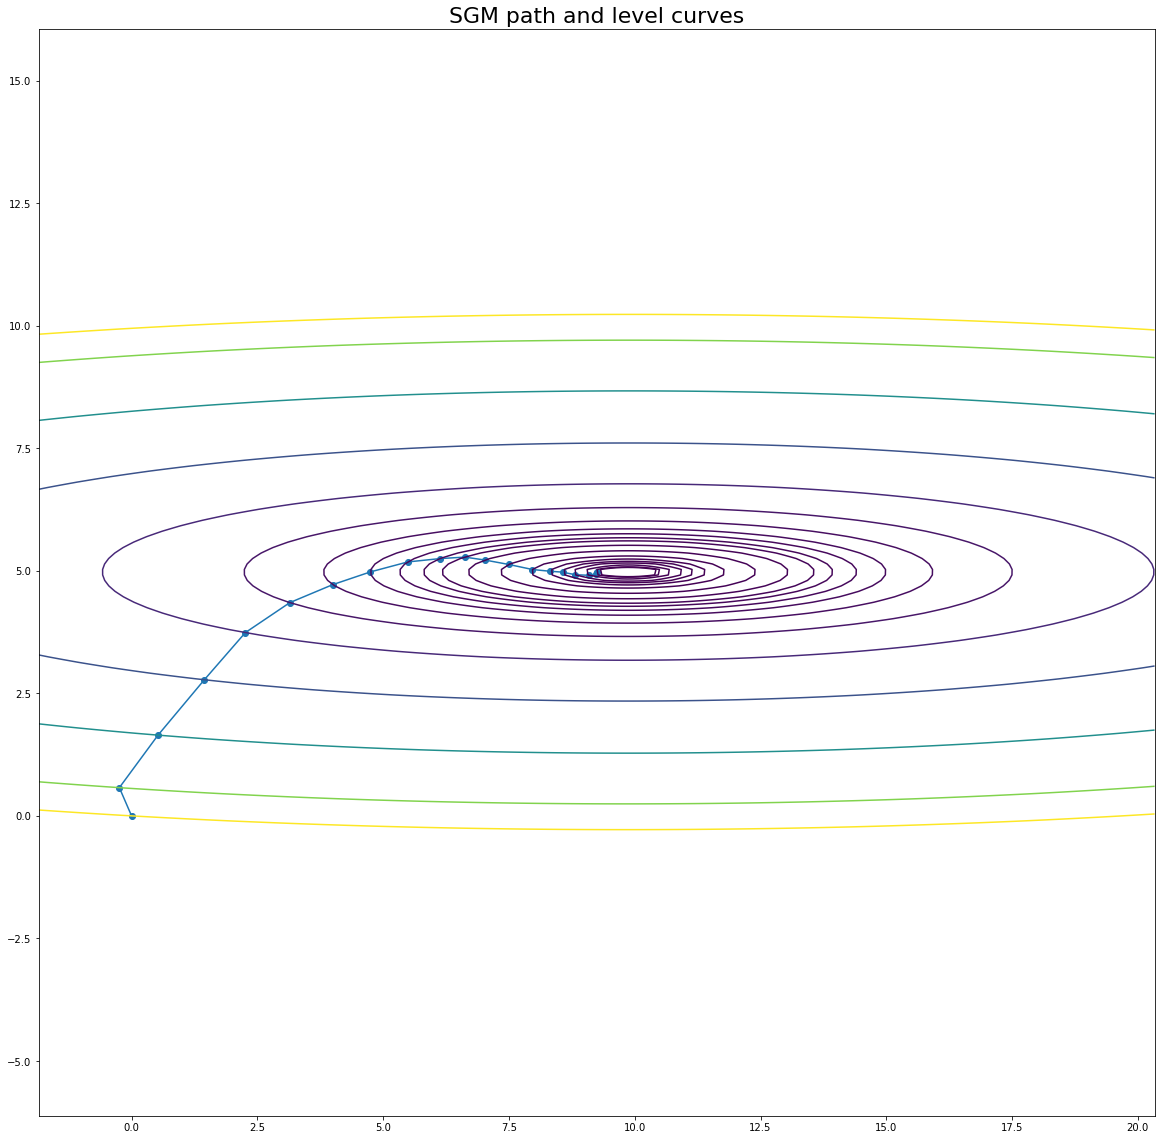

In [98]:
"""
Finds minimum of the function using stochastic gradient descent with momentum.

Отличие от обычного SGD в том, что добавился параметр b. Теперь при вычислении градиента в новой точке можно учитывать градиент во всех предыдущих. Чем дальше номер точки от текущего номера, тем меньший вклад градиент в ней вносит в текущий градиент. Такой подход призван предотвратить излишние колебания минимизируемой функции вблизи её минимума.

@param b: weight of gradient in previous points
"""
def sgd_momentum(sum_fun:List[Callable[[ndarray], float]], x:ndarray, max_epoch:int, batch_size:int, lr:List[float], b:List[float] = (0), scheduler:Callable[[List[float]], float] = lambda lr: lr, stop_criteria:Callable[[List[float]], bool]=lambda x: False) -> ndarray:
    lr = np.array(lr)
    points = [x]
    g = np.zeros(len(x))
    for i in range(1, max_epoch):
        if stop_criteria(x): break
        g = b * g + scheduler(lr) * np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        x = x - 1 / batch_size * g
        points.append(x)
    return np.array(points)

a = [10, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = [60, 5]
b = [0.5]

points = sgd_momentum(sum_fun, x, epoch, batch_size, lr, b)

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## Nesterov SGD

Precision: [8.73767995 3.57639104]
Min point: [1.26232005 1.42360896]
Iterations: 20
Path: [[0.         0.        ]
 [0.01217637 0.15613411]
 [0.03525734 0.1411551 ]
 [0.05825033 0.29298685]
 [0.09540768 0.31749831]
 [0.1336681  0.44892364]
 [0.18540001 0.46025909]
 [0.24909633 0.59855779]
 [0.31806084 0.61177036]
 [0.39106312 0.74161653]
 [0.46351954 0.7584207 ]
 [0.53783188 0.88644601]
 [0.62062992 0.8994509 ]
 [0.71658205 1.01668713]
 [0.80500592 1.04750337]
 [0.90177811 1.15625599]
 [0.99418316 1.19060496]
 [1.08247694 1.28419741]
 [1.17327561 1.31385558]
 [1.26232005 1.42360896]]


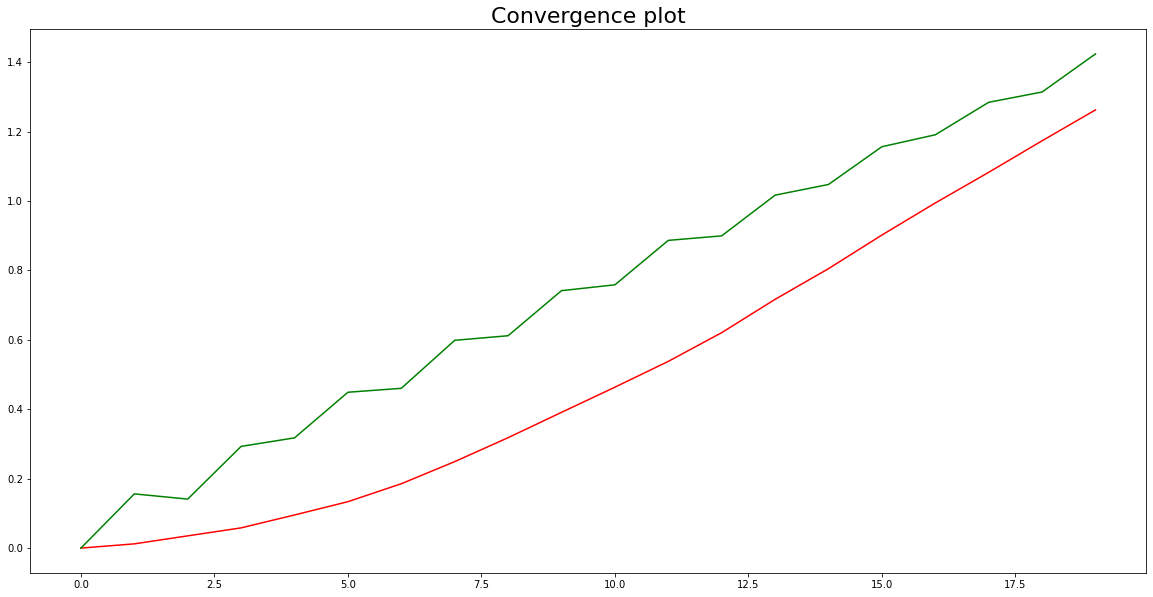

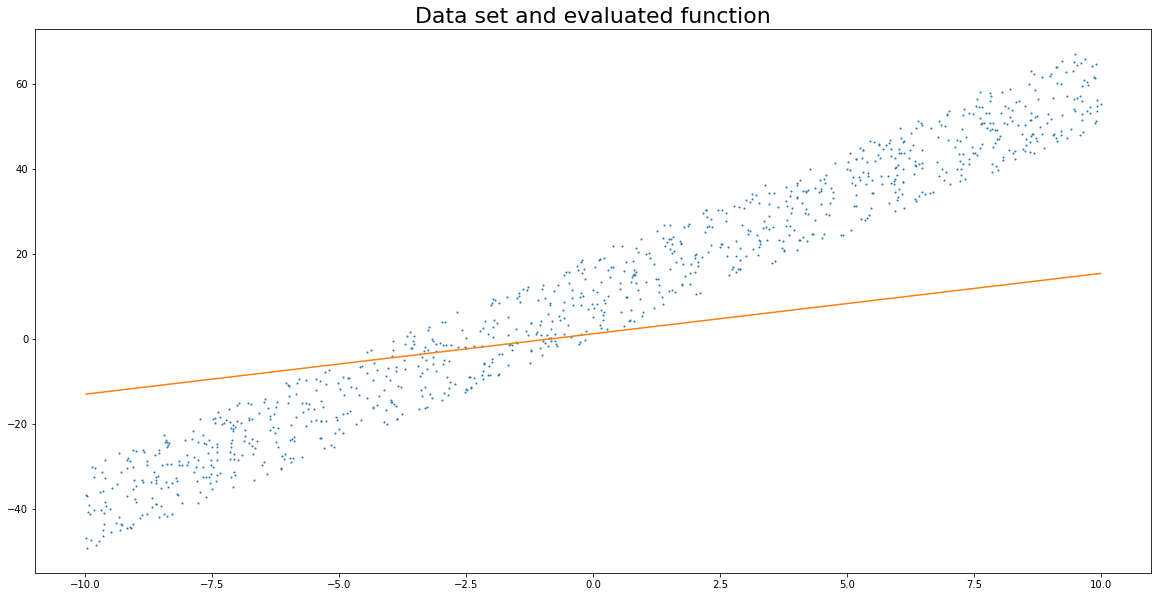

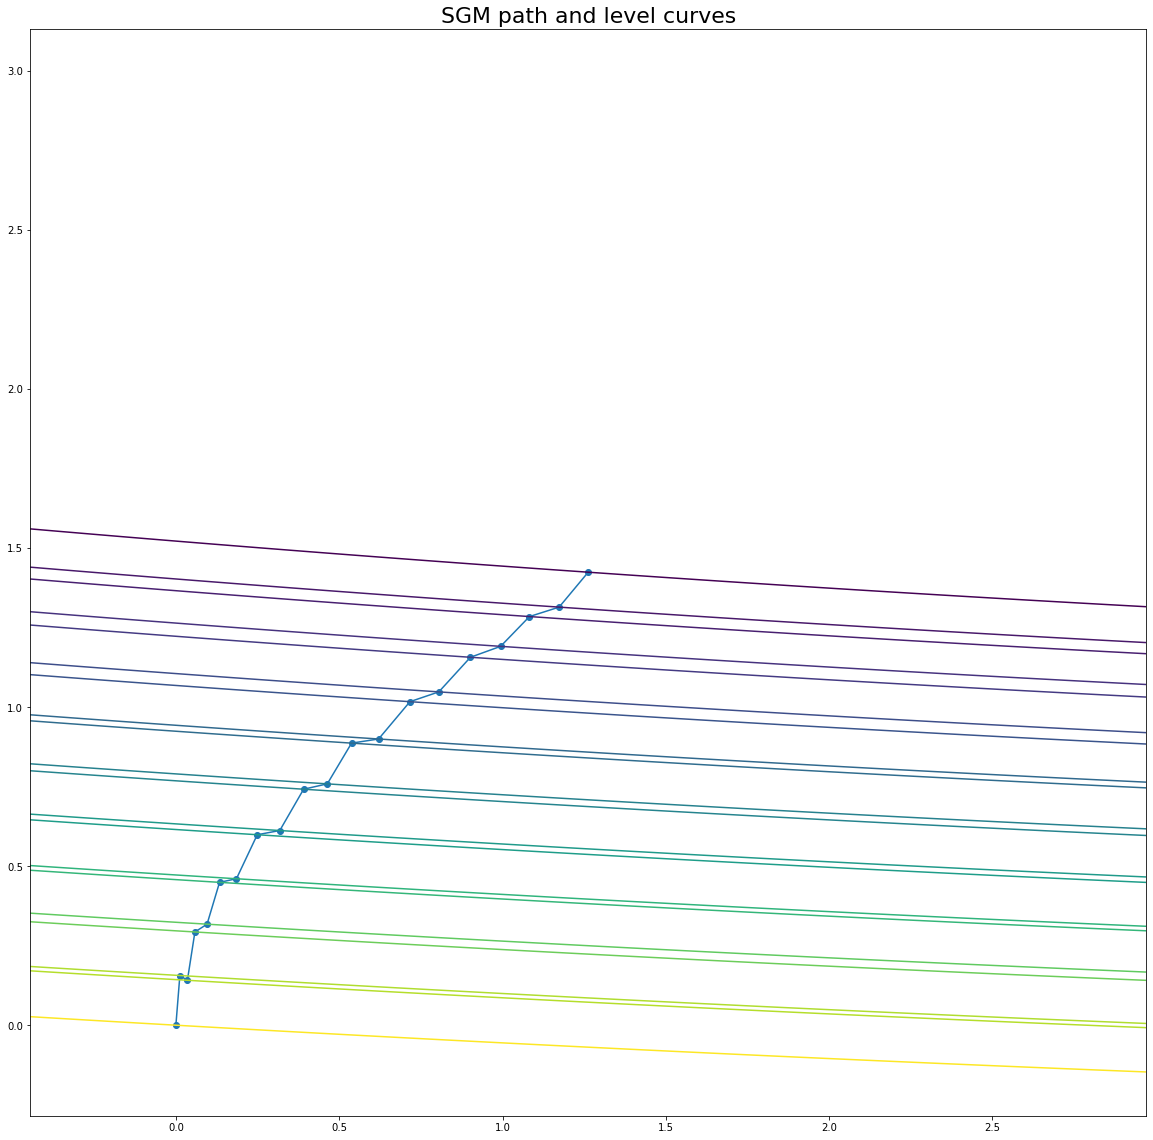

In [99]:
"""
Finds minimum of the function using stochastic gradient descent with Nesterov algorithm.

Аналогична SGD with momentum, но в добавок вычисляет градиент на каждом шаге, не в точке x, а в точке x - b * g, где g - направление спуска на прошлом шаге.

По неизвестным причинам такой спуск работает невероятно плохо. Он либо сходится крайне медленно, либо чрезвычайно быстро расходится. Притом грань между сходимость и расходимостью очень тонкая.

@param b: weight of gradient in previous points
"""
def sgd_nesterov(sum_fun:List[Callable[[ndarray], float]], x:ndarray, max_epoch:int, batch_size:int, lr:List[float], b:List[float] = (0), scheduler:Callable[[List[float]], float] = lambda lr: lr, stop_criteria:Callable[[List[float]], bool]=lambda x: False) -> ndarray:
    lr = np.array(lr)
    points = [x]
    g = np.zeros(len(x))
    for i in range(1, max_epoch):
        if stop_criteria(x): break
        g = b * g + scheduler(lr) * np.array(grad_appr(sum_fun, x - b * g, [(i - 1) * batch_size, batch_size]))
        x = x - 1 / batch_size * g
        points.append(x)
    return np.array(points)

a = [10, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 60
lr = [2, 1]
b = [0.9]

points = sgd_nesterov(sum_fun, x, epoch, batch_size, lr, b)

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## SGD with AdaGrad

Precision: [0.44747411 0.21951314]
Min point: [19.55252589  4.78048686]
Iterations: 20
Path: [[ 0.          0.        ]
 [19.99999985 19.99999998]
 [28.53211321  1.85185521]
 [23.05142452  5.93494889]
 [19.88571161  4.11967499]
 [20.40374372  5.25987584]
 [19.69397329  4.65749215]
 [19.5707387   5.10408846]
 [20.10473076  4.72503362]
 [20.45200088  5.07036401]
 [19.98714985  4.99680454]
 [20.27935283  4.95198316]
 [20.52779098  5.1179262 ]
 [19.40234939  5.21950908]
 [19.26758273  5.26157093]
 [20.05521686  4.85721113]
 [20.52310355  5.06907657]
 [19.41808967  4.87943382]
 [20.57266538  5.11136776]
 [19.55252589  4.78048686]]


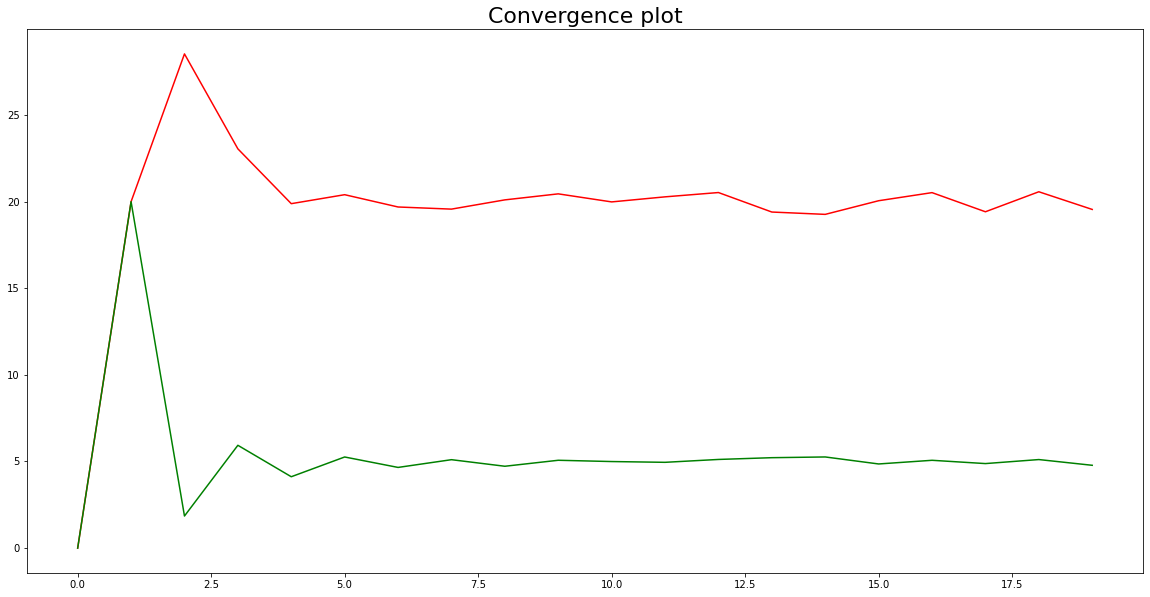

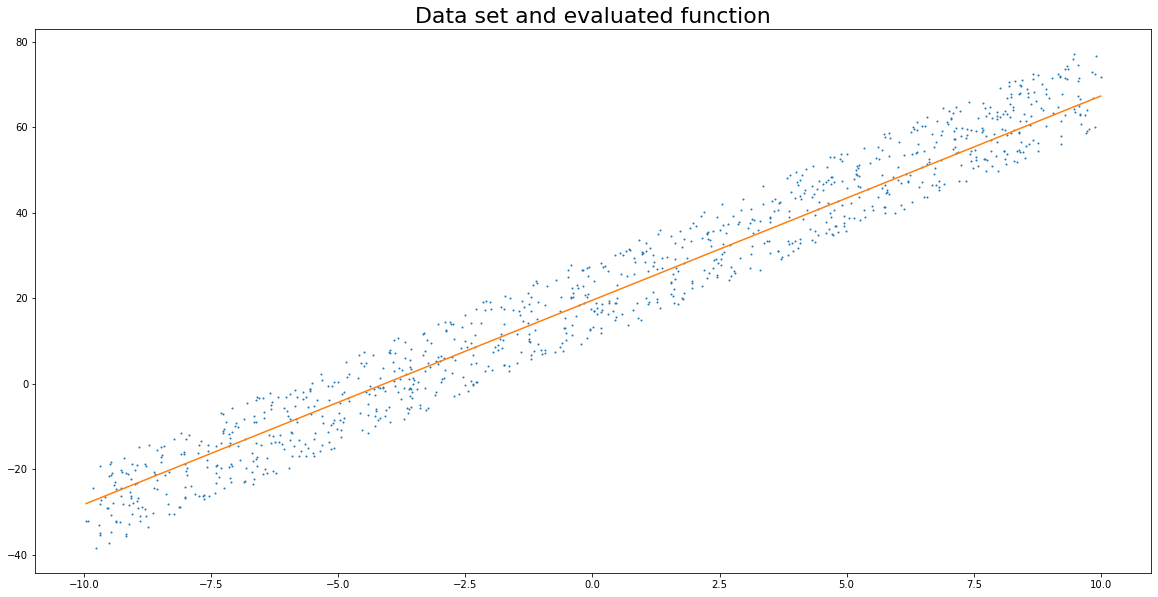

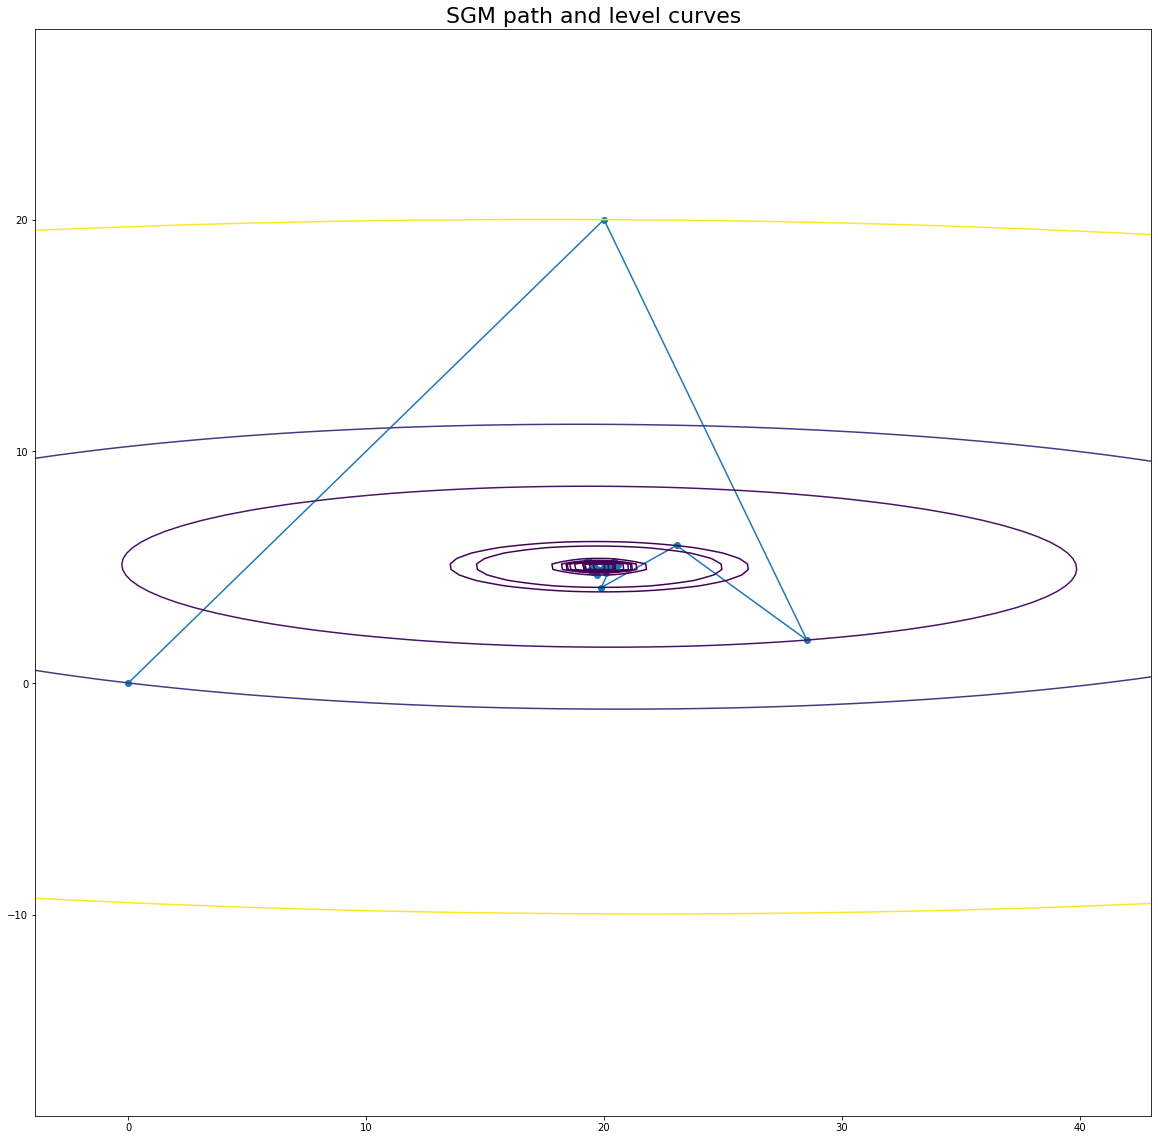

In [100]:
"""
Finds minimum of the function using stochastic gradient descent with AdaGrad (adaptive gradient).

Теперь величина шага накапливается в переменной v. С помощью накопленной величины редактируется размер шага в направлении антиградиента на текущей итерации. Само направление при этом выбирается стандартным образом.

Уменьшает колебания. Даёт возможность использовать одинаковый lr по всем направлениям даже без использования scaler.
"""
def sgd_adagrad(sum_fun:List[Callable[[ndarray], float]], x:ndarray, max_epoch:int, batch_size:int, lr:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr, stop_criteria:Callable[[List[float]], bool]=lambda x: False) -> ndarray:
    lr = np.array(lr)
    points = [x]
    v = np.zeros(len(x))
    for i in range(1, max_epoch):
        if stop_criteria(x): break
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        v += np.square(g)
        x = x - 1 / (np.sqrt(v) + 1e-8) * 1 / batch_size * scheduler(lr) * g
        points.append(x)
    return np.array(points)

a = [20, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 50
lr = 1000

points = sgd_adagrad(sum_fun, x, epoch, batch_size, lr)

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## SGD with RMSProp

Precision: [-0.12808908 -0.13713506]
Min point: [15.12808908  5.13713506]
Iterations: 20
Path: [[ 0.          0.        ]
 [ 3.79473303  3.79473318]
 [ 5.70151769  4.25585481]
 [ 7.8291359   5.06329764]
 [ 9.18695661  4.65115053]
 [10.17293673  4.90557466]
 [11.19962084  4.84141261]
 [12.05713708  4.98692085]
 [12.87518151  4.91780023]
 [13.65341634  4.97596973]
 [14.29128211  4.93621298]
 [14.18798395  5.00849438]
 [14.25307292  4.76208243]
 [14.14046896  4.87641275]
 [14.08935624  4.87816339]
 [14.30236113  5.18117809]
 [14.71898484  4.8806154 ]
 [14.597583    4.64542803]
 [14.7576399   5.14939589]
 [15.12808908  5.13713506]]


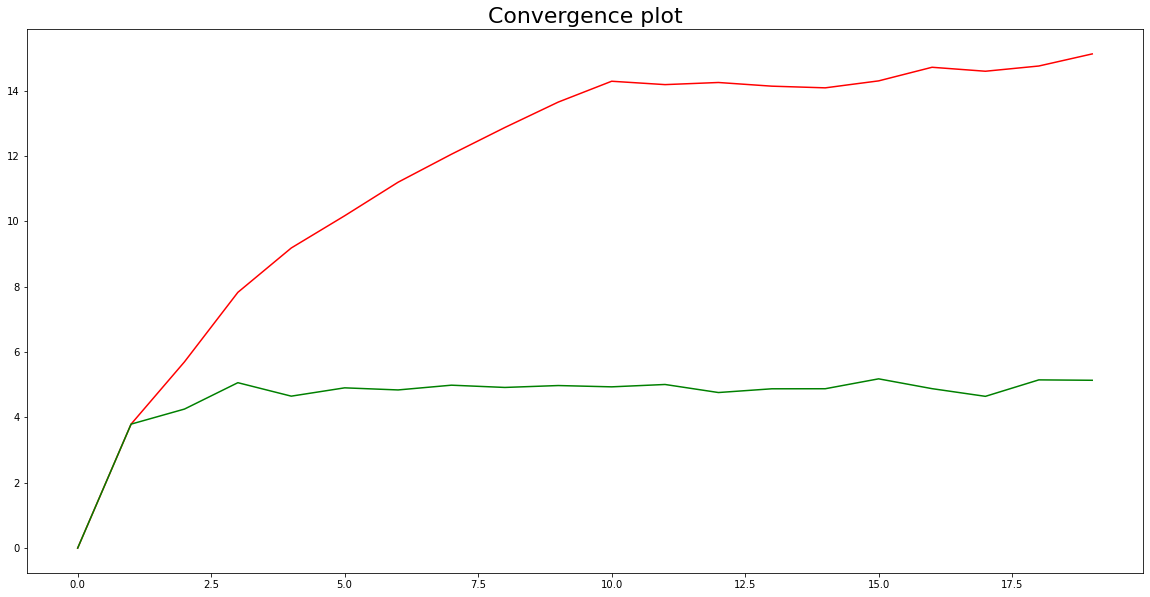

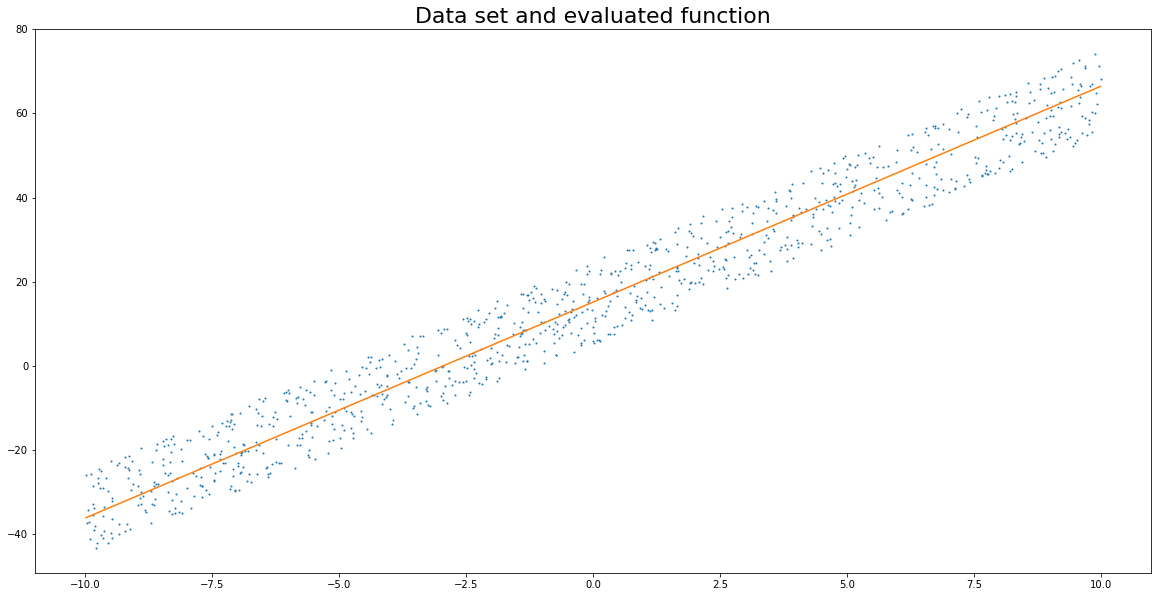

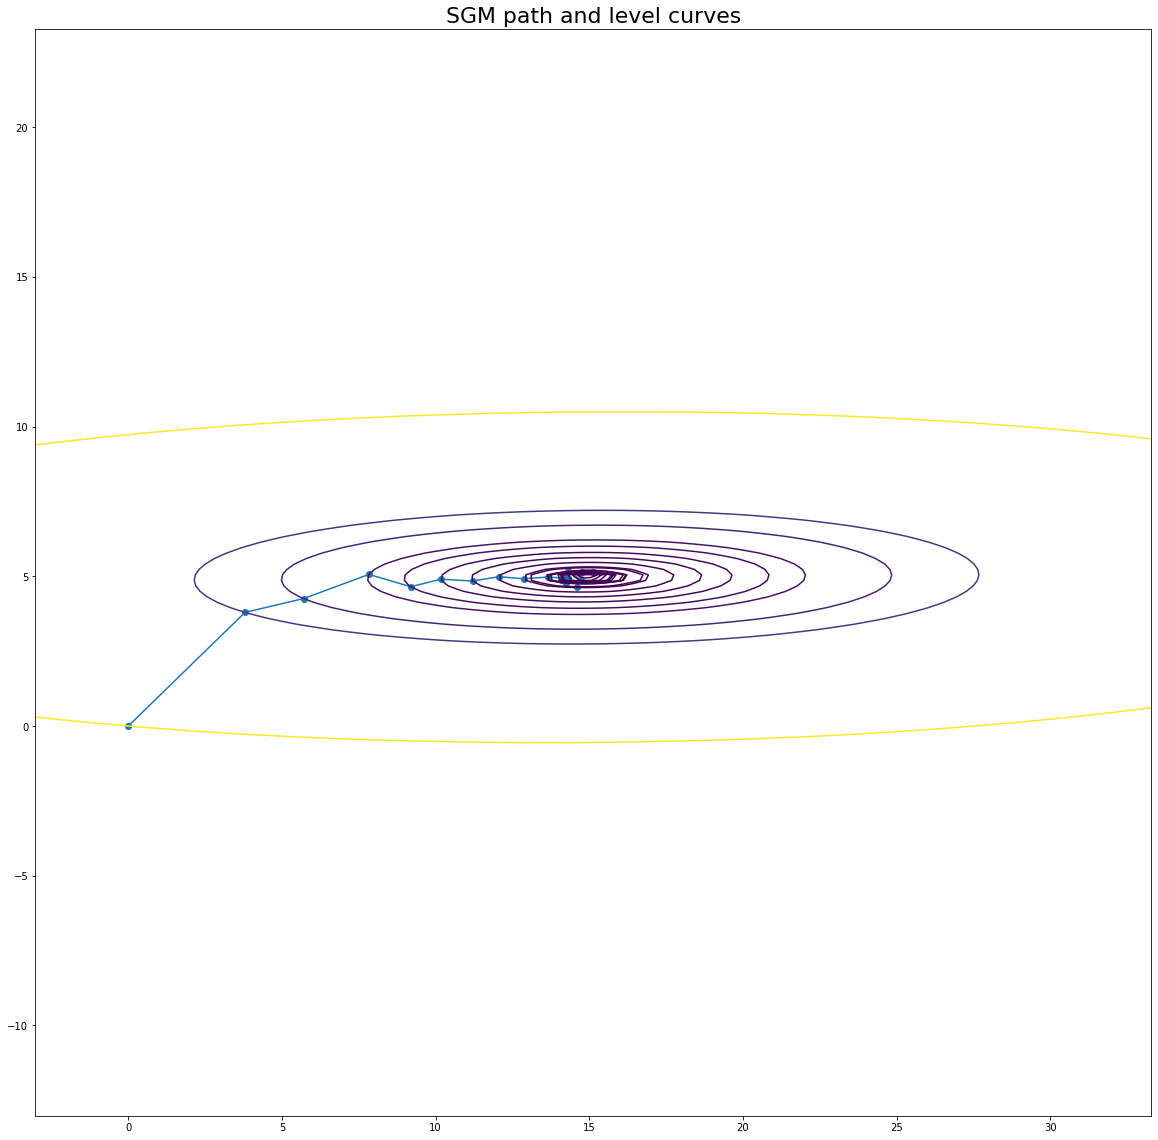

In [101]:
"""
Finds minimum of the function using stochastic gradient descent with rmsprop.

Алгоритм действует аналогично AdaGrad, но теперь шаг накапливается с инерцией, изменяясь, как скользящее среднее шагов на прошлых итерациях.

@param b: weight of steps (euclid norm of gradient) in previous points
"""
def sgd_rmsprop(sum_fun:List[Callable[[ndarray], float]], x:ndarray, max_epoch:int, batch_size:int, lr:List[float], b:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr, stop_criteria:Callable[[List[float]], bool]=lambda x: False) -> ndarray:
    lr = np.array(lr)
    b = np.array(b)
    points = [x]
    v = 0
    for i in range(1, max_epoch):
        if stop_criteria(x): break
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        v = b * v + (1 - b) * np.square(g)
        x = x - 1 / (np.sqrt(v) + 1e-8) * 1 / batch_size * scheduler(lr) * g
        points.append(x)
    return np.array(points)


a = [15, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 50
lr = 60
b = 0.9

points = sgd_rmsprop(sum_fun, x, epoch, batch_size, lr, b)

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## SGD with Adam

Precision: [-1.12044833  0.02704819]
Min point: [16.12044833  4.97295181]
Iterations: 20
Path: [[ 0.          0.        ]
 [ 2.85368819  2.85368827]
 [ 5.56279905  5.14973502]
 [ 7.69741824  6.35175137]
 [ 9.28845815  6.70416027]
 [10.53330075  6.5153219 ]
 [11.49770658  6.12250621]
 [12.22348272  5.70721591]
 [13.12730002  5.12087367]
 [13.76188447  4.73850397]
 [14.33789689  4.62796423]
 [14.78151642  4.75267786]
 [15.13051618  4.81204644]
 [14.91408948  4.87095347]
 [14.58331115  5.12833584]
 [14.38596292  5.556164  ]
 [14.30684524  4.88605658]
 [14.85788699  4.5124457 ]
 [15.47344179  4.32080014]
 [16.12044833  4.97295181]]


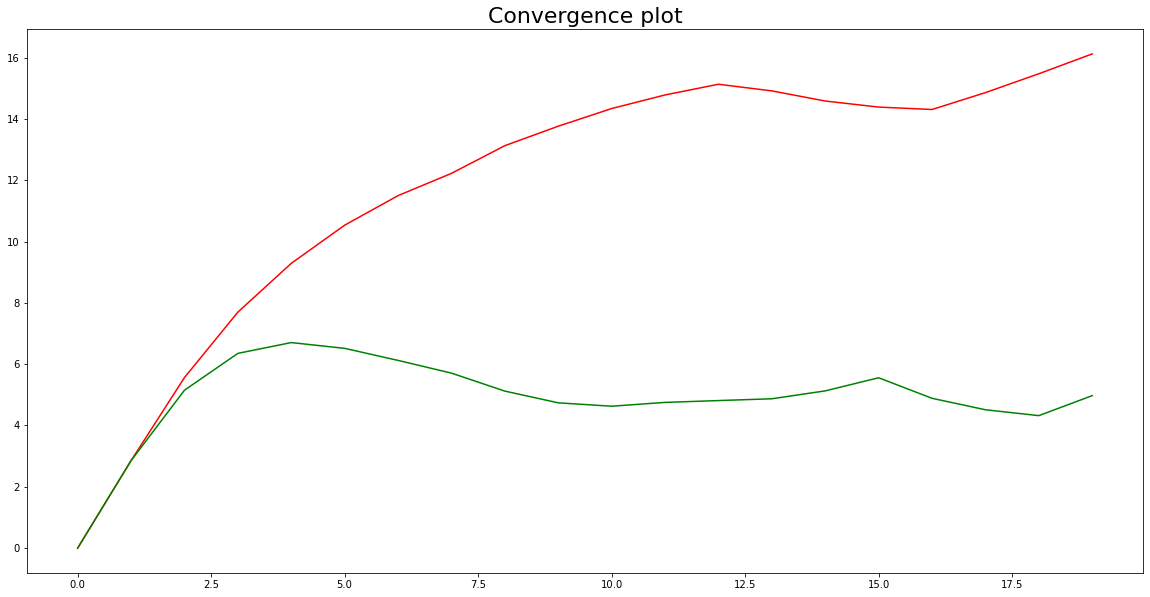

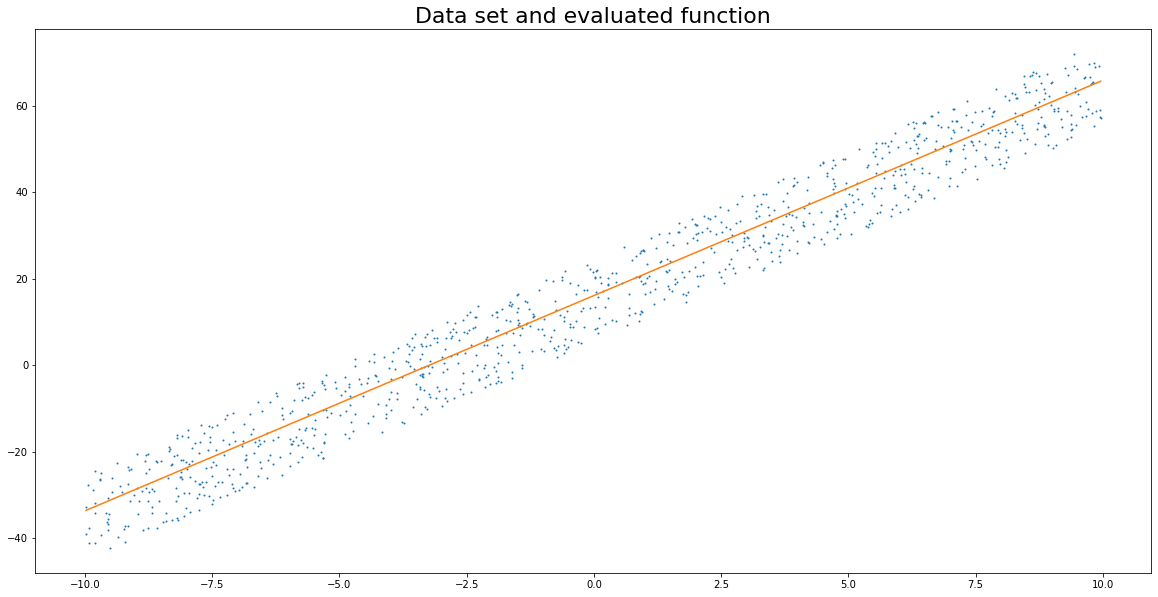

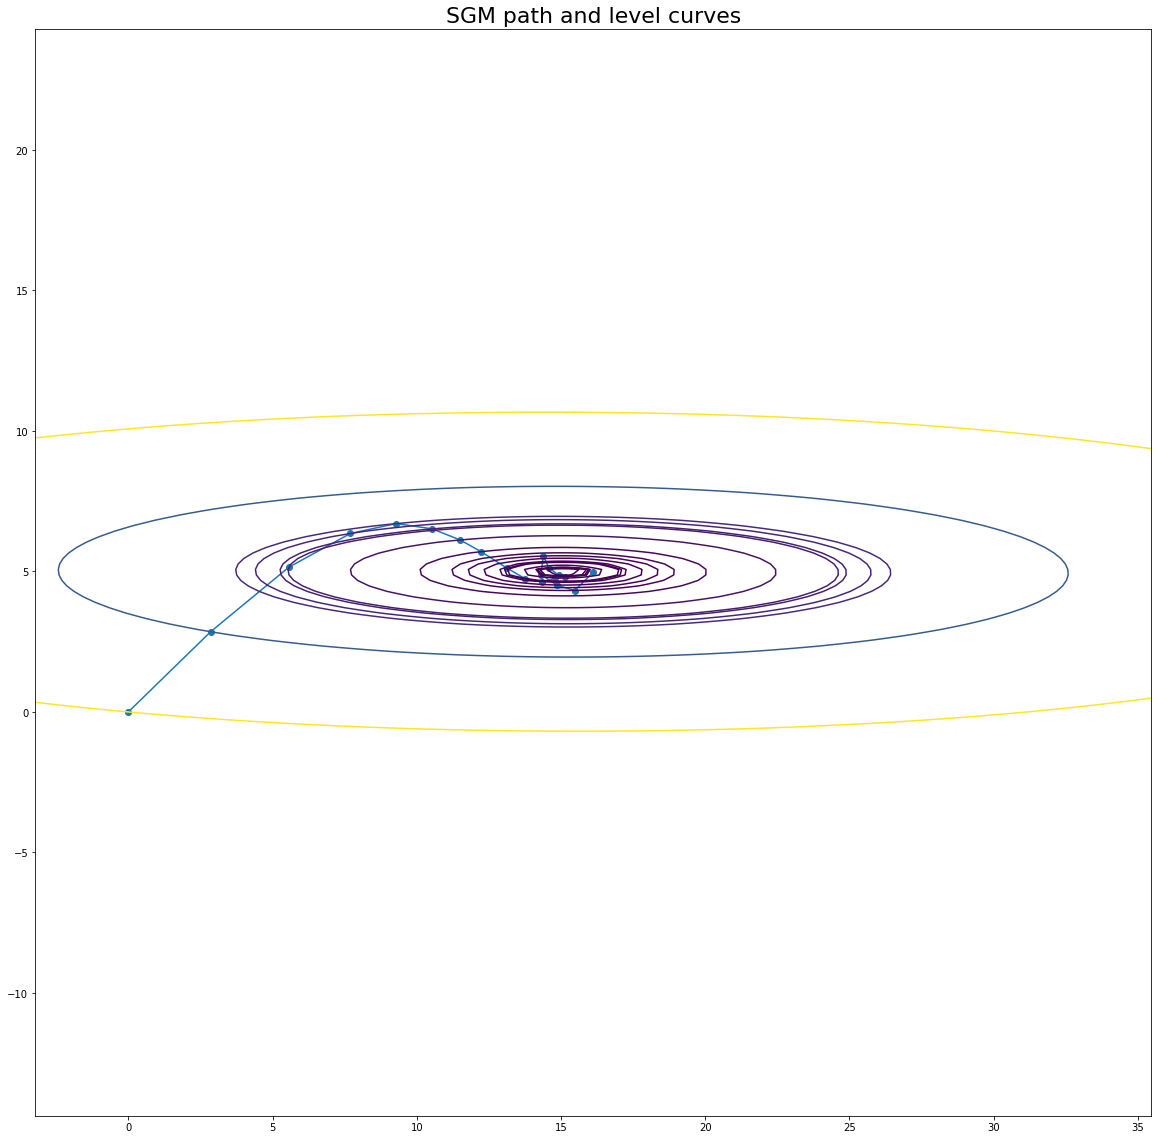

In [102]:
"""
Finds minimum of the function using stochastic gradient descent with adam.

Adam вобрал в себя идеи RMSProp и SGD with momentum. Теперь и величина шага, и направление шага корректируются, как скользящее среднее величины шага и его направления на прошлых итерациях.

Подобный подход позволяет значительно уменьшить колебания спуска вблизи минимума. Более того, этот алгоритм, как и RMSProp, будет хорошо сходиться даже в условиях отсутствия предварительной нормировки данных, с одинаковым lr по всем направлениям (features).

Возможно, этот алгоритм на даёт лучшей сходимости всегда, но он определённо надеждней многих прочих в большинстве случаев.

@param b1: weight of gradient in previous points
@param b2: weight of steps (euclid norm of gradient) in previous points
"""
def sgd_adam(sum_fun:List[Callable[[ndarray], float]], x:ndarray, max_epoch:int, batch_size:int, lr:List[float], b1:List[float], b2:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr, stop_criteria:Callable[[List[float]], bool]=lambda x: False) -> ndarray:
    lr = np.array(lr)
    b1, b2 = np.array(b1), np.array(b2)
    points = [x]
    m = 0
    v = 0
    for i in range(1, max_epoch):
        if stop_criteria(x): break
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))

        m = b1 * m + (1 - b1) * g
        v = b2 * v + (1 - b2) * np.square(g)

        m = m / (1 - np.power(b1, i))
        v = v / (1 - np.power(b2, i))

        x = x - 1 / (np.sqrt(v) + 1e-8) * 1 / batch_size * scheduler(lr) * m
        points.append(x)
    return np.array(points)

a = [15, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = 60
b1 = 0.5
b2 = 0.7
scheduler = lambda lr: lr * np.exp(-0.05)

points = sgd_adam(sum_fun, x, epoch, batch_size, lr, b1, b2, scheduler=scheduler)

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## Траектория спуска обычного SGD для одномерного пространства регрессоров
На графике также отображены линии равного уровня минимизируемой функции

Precision: [ 0.47710738 -0.1025283 ]
Min point: [ 9.52289262 -2.8974717 ]
Iterations: 40
Path: [[ 0.          0.        ]
 [ 0.9138631  -0.30915146]
 [ 1.14675899 -0.59706794]
 [ 1.57737441 -0.78044115]
 [ 1.67313562 -0.94220217]
 [ 2.14586988 -1.13589053]
 [ 2.84069703 -1.40017579]
 [ 3.53324561 -1.57479132]
 [ 4.22426912 -1.72654061]
 [ 4.50575252 -1.80697378]
 [ 4.83867715 -1.88395217]
 [ 5.29766861 -2.06057435]
 [ 5.81105638 -2.14124359]
 [ 6.19547696 -2.18884871]
 [ 6.2775838  -2.31271166]
 [ 6.30010701 -2.4100942 ]
 [ 6.59242524 -2.4751354 ]
 [ 6.90865353 -2.51227879]
 [ 6.91069304 -2.56499229]
 [ 6.94127851 -2.610569  ]
 [ 7.04580479 -2.61942198]
 [ 7.21941327 -2.61157992]
 [ 7.50261683 -2.62290674]
 [ 7.66194334 -2.60448973]
 [ 7.81101112 -2.63901078]
 [ 7.8534764  -2.69189516]
 [ 8.07033879 -2.75309168]
 [ 8.16789066 -2.77898798]
 [ 8.34663541 -2.80592274]
 [ 8.36977093 -2.82650857]
 [ 8.54066072 -2.81719531]
 [ 8.70578074 -2.82877798]
 [ 8.86016802 -2.79992012]
 [ 8.99671542 

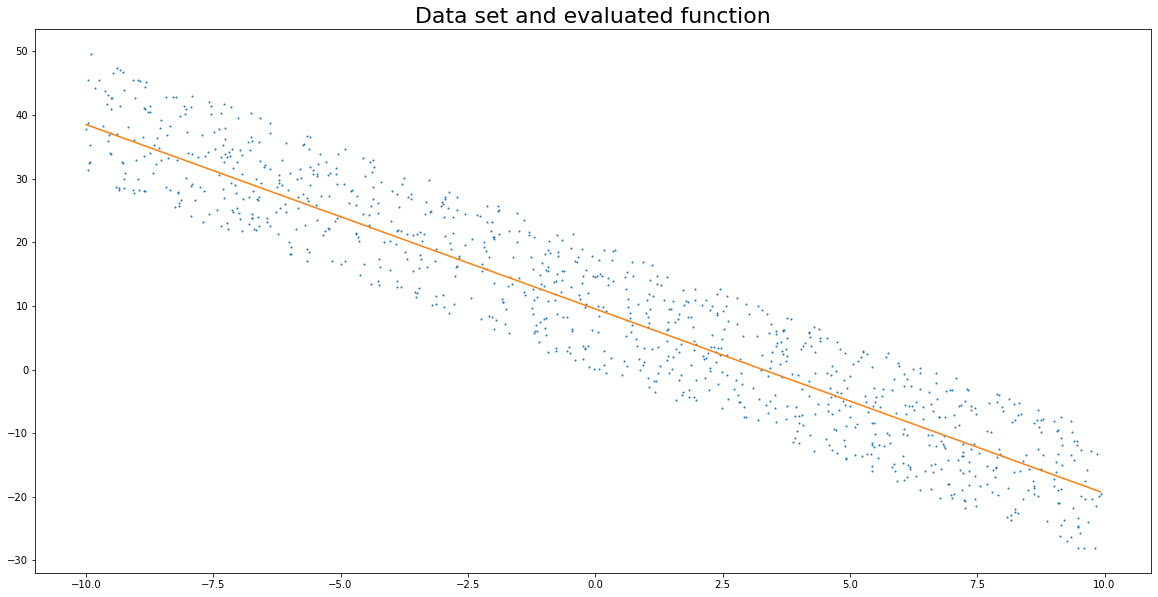

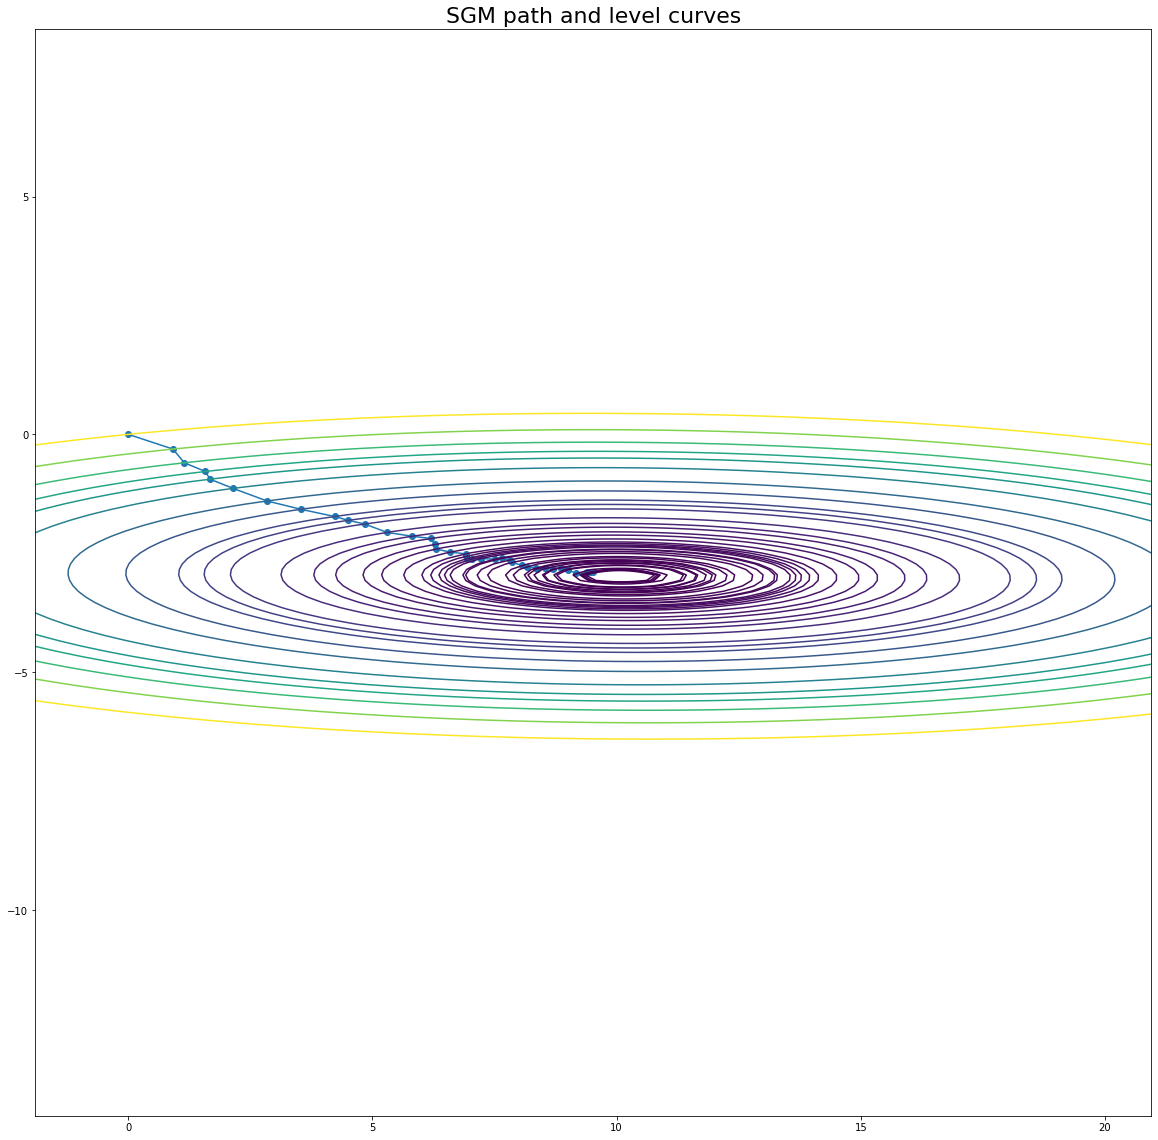

In [103]:
a = [10, -3]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 40
batch_size = 20
lr = [70, 3]

points = sgd(sum_fun, x, epoch, batch_size, lr)

print_result(a, points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)